In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!ln -s "/content/drive/My Drive/Borderline/" "/content/"


In [3]:
%cd Borderline

/content/drive/My Drive/Borderline


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import Subset, DataLoader, random_split, Dataset
from torch.optim import lr_scheduler
import torch.utils.data as data
from torchvision import transforms
from transformers import BertTokenizer, AdamW
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np
import os
import time
import copy
import random
import pandas as pd

Model

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, embed_size, heads, ff_hidden_size, dropout_rate):
        super(EncoderLayer, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads, dropout=dropout_rate)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, ff_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(ff_hidden_size, embed_size),
        )
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        attn_output, _ = self.attention(src, src, src, attn_mask=src_mask,
                                        key_padding_mask=src_key_padding_mask)
        src = src + self.dropout(attn_output)
        src = self.norm1(src)

        ff_output = self.feed_forward(src)
        src = src + self.dropout(ff_output)
        src = self.norm2(src)

        return src

class BERTModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, ff_hidden_size, num_layers, dropout_rate, max_position_embeddings, num_segments):
        super(BERTModel, self).__init__()

        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.segment_embedding = nn.Embedding(num_segments, embed_size)
        self.position_embedding = nn.Embedding(max_position_embeddings, embed_size)

        self.layers = nn.ModuleList([EncoderLayer(embed_size, num_heads, ff_hidden_size, dropout_rate) for _ in range(num_layers)])
        self.pooler = nn.Linear(embed_size, embed_size)
        self.dropout = nn.Dropout(dropout_rate)

        # Adjusted classification head for 3-class classification
        self.classifier = nn.Linear(embed_size, 2)  # Output logit for each class

    def forward(self, x, segments):
        seq_length = x.size(1)
        position_ids = torch.arange(0, seq_length, dtype=torch.long, device=x.device).unsqueeze(0)

        token_embeddings = self.token_embedding(x)
        segment_embeddings = self.segment_embedding(segments)
        position_embeddings = self.position_embedding(position_ids)

        embeddings = token_embeddings + segment_embeddings + position_embeddings
        embeddings = self.dropout(embeddings)

        for layer in self.layers:
            embeddings = layer(embeddings)

        pooled_output = self.pooler(embeddings[:, 0])
        pooled_output = torch.tanh(pooled_output)

        # Directly output logits for multi-class classification
        logits = self.classifier(pooled_output)

        return logits


Hyperparameters

In [6]:
max_len = 128
batch_size = 32
lr = 2e-5
vocab_size = 30522
embed_size = 768
num_heads =  12
ff_hidden_size = 3072
num_layers = 12
dropout_rate = 0.1
max_position_embeddings = 512
num_segments = 2

Dataset

In [7]:
class TweetsDataset(Dataset):
    def __init__(self, filename, tokenizer, max_len):

        self.data = pd.read_csv(filename)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tweet = self.data.loc[index, 'text']
        label = self.data.loc[index, 'label']
        if label == 'hate' :
          label = 1
        else :
          label = 0
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',  # Return PyTorch tensors
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

In [8]:
csv_path = 'data/data.csv'
tokenizer = tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = TweetsDataset(csv_path, tokenizer, max_len)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

EDA

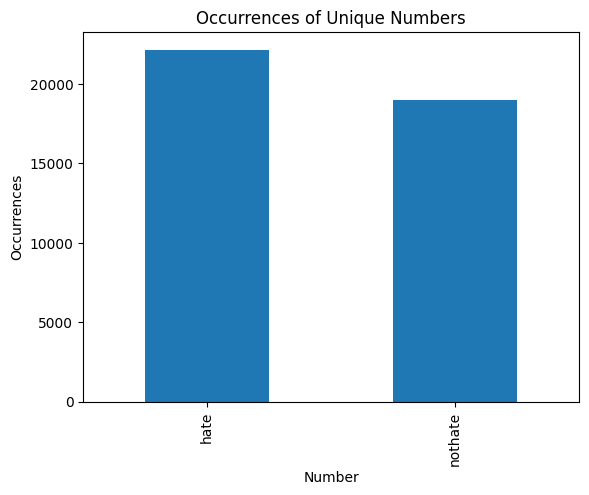

In [9]:
eda = pd.read_csv(csv_path)
class_count = eda['label'].value_counts()

class_count.plot(kind='bar')

# Setting the title and labels
plt.title('Occurrences of Unique Numbers')
plt.xlabel('Number')
plt.ylabel('Occurrences')

# Showing the plot
plt.show()

Computing weighted BCE loss to tacke the unmbalanced dataset

In [10]:
class_0 = class_count[0]
class_1 = class_count[1]
total_samples = class_0 + class_1

In [11]:
weight_for_0 = (1 / class_0) * (total_samples / 2.0)
weight_for_1 = (1 / class_1) * (total_samples / 2.0)

In [12]:
weights = torch.tensor([weight_for_0, weight_for_1]).float()
loss_fn = nn.CrossEntropyLoss(weight=weights)

In [13]:
dataset_size = len(dataset)
dataset_indices = list(range(dataset_size))
train_indices, temp_indices = train_test_split(dataset_indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)


train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

In [14]:
model = BERTModel(vocab_size, embed_size, num_heads,
                        ff_hidden_size, num_layers, dropout_rate,
                        max_position_embeddings, num_segments)

In [15]:
optimizer = Adam(model.parameters(), lr=lr)

Training Function

In [16]:
def train(model, train_loader, optimizer, criterion, val_loader, learning_rate, n_epochs):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)

    # Initialize best_model with the initial state of the model
    best_model = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    best_epoch = 0

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total = 0


        for batch_idx, batch in enumerate(train_loader):  # Enumerate to get batch index
            optimizer.zero_grad()


            inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
            segments = torch.zeros_like(inputs).to(device)

            outputs = model(inputs, segments)

            labels = labels.to(torch.int64)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted_classes = torch.max(outputs, dim=1)
            total_correct += (predicted_classes == labels).sum().item()
            total += labels.size(0)



        train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / total
        print(f'Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}')

        # Validation loop remains mostly the same
        if val_loader:
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for batch in val_loader:
                    inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted_classes = torch.max(outputs, dim=1)
                    val_correct += (predicted_classes == labels).sum().item()
                    val_total += labels.size(0)

            val_loss = val_loss / len(val_loader)
            val_accuracy = val_correct / val_total
            print(f'Epoch {epoch+1}/{n_epochs} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(model.state_dict())
                best_epoch = epoch
                print(f'New best model saved with val loss: {best_val_loss:.4f}')

    # Finalization remains the same
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), f'model_epoch{best_epoch}.pth')
    print('Training complete.')
    return model


In [ ]:
best_model = train(model, train_loader, optimizer, loss_fn, val_loader=None, learning_rate=1e-4, n_epochs=10)

Epoch 1/10, Batch 0/1029, Loss: 0.7996
Epoch 1/10, Batch 100/1029, Loss: 0.6924
Epoch 1/10, Batch 200/1029, Loss: 0.6882
Epoch 1/10, Batch 300/1029, Loss: 0.6873
Epoch 1/10, Batch 400/1029, Loss: 0.6965
Epoch 1/10, Batch 500/1029, Loss: 0.6851
Epoch 1/10, Batch 600/1029, Loss: 0.7429
Epoch 1/10, Batch 700/1029, Loss: 0.7075
Epoch 1/10, Batch 800/1029, Loss: 0.6845
Epoch 1/10, Batch 900/1029, Loss: 0.6015
Epoch 1/10, Batch 1000/1029, Loss: 0.6963
Epoch 1/10 | Train Loss: 0.6883 | Train Accuracy: 0.5358
Epoch 2/10, Batch 0/1029, Loss: 0.6896
Epoch 2/10, Batch 100/1029, Loss: 0.7035
Epoch 2/10, Batch 200/1029, Loss: 0.6945
Epoch 2/10, Batch 300/1029, Loss: 0.6946
Epoch 2/10, Batch 400/1029, Loss: 0.6246
Epoch 2/10, Batch 500/1029, Loss: 0.6736
Epoch 2/10, Batch 600/1029, Loss: 0.6774
Epoch 2/10, Batch 700/1029, Loss: 0.7026
Epoch 2/10, Batch 800/1029, Loss: 0.6611
Epoch 2/10, Batch 900/1029, Loss: 0.6849
Epoch 2/10, Batch 1000/1029, Loss: 0.6590
Epoch 2/10 | Train Loss: 0.6837 | Train Acc